# Homework 2: Geospatial Analysis
## EDS 296

Author: Michelle Yiv

[Link to github repository](https://github.com/mmyiv/eds296-mapping.git)

Github Repo: https://github.com/mmyiv/eds296-mapping.git

## Step 1: Setup

Using the CMIP6 database hosted on Amazon Web Services, choose any two models you like: use both their historical simulations and future projections from one of the four major SSPs (ssp126, ssp245, ssp370, or ssp585). Provide a brief description of the models and scenarios you chose to include.

In [1]:
# Load packages
import xarray as xr
import matplotlib.pyplot as plt

import intake
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


## Choose two models with two historical simulations & future projections. Let's choose CanESM5 and CESM2 models for ssp370

CanESM5 stands for the Canadian Earth System Model version 5. This model is run by the Environment and Climate Change Canada Centre, and is used to simulate both historical climate change data and future projections for 100 years (Swart et al. 2019).

CESM2 stands for Community Earth System Model version 2 and is a model developed by the National Center for Atmospheric Research. This model also contains historical and future projections (1850-2100). This model includes improved representations, such as the Community Land Model version 5 (CLM5), the Parallel Ocean Program version 2 (POP2), and the Community Ice Sheet Model version 2 (CISM2) (Danabasoglu et al., 2020).

The scenario ssp370 is a high emissions scenario, although not as high as ssp585. ssp370 is from the increase of greenhouse gases and global warning leading to adding add 7 watts of heat energy per square meter of Earth's surface (7 W/m² by 2100).

### Access the catalogue and choose a climate variable: tas for Surface air temperature

In [2]:
# Open the CMIP6 data catalog
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [3]:
# Find historical simulations from two models
res_can = catalog.search(activity_id="CMIP", experiment_id="historical", source_id="CanESM5")
res_ces = catalog.search(activity_id="CMIP", experiment_id="historical", source_id="CESM2")

# Convert these to dataframes
res_can_df = res_can.df
res_ces_df = res_ces.df

# Print all unique ensemble members ("member_id")
members_can = res_can_df.member_id.unique()
members_ces = res_ces_df.member_id.unique()

# print(members_can)
# print(members_ces)

Let's specify member as 'r10i1p1f1' as both models have this (Although that isn't necessary, it is easier!)

In [4]:
# Specify search terms

# Specifiy timing
activityid_hist = ['CMIP']
activityid_fut = ['ScenarioMIP']
experimentid_hist = ['historical']
experimentid_fut = ['ssp370']

# Common search terms
memberid = ['r10i1p1f1']
tableid = ['Amon']
variableid = ['tas']

# CanESM5 
sourceid_can = ['CanESM5']

# CESM2
sourceid_ces = ['CESM2']

In [5]:
# Search through catalog & store results for both models 

# CANESM5
res_can_hist = catalog.search(
    activity_id= activityid_hist,
    source_id= sourceid_can,
    experiment_id= experimentid_hist,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

res_can_fut = catalog.search(
    activity_id= activityid_fut,
    source_id= sourceid_can,
    experiment_id= experimentid_fut,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

# Cesm2 
res_ces_hist = catalog.search(
    activity_id= activityid_hist,
    source_id= sourceid_ces,
    experiment_id= experimentid_hist,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

res_ces_fut = catalog.search(
    activity_id= activityid_fut,
    source_id= sourceid_ces,
    experiment_id= experimentid_fut,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

In [6]:
# Show both model results as a dataframe
display(res_can_hist.df)
display(res_can_fut.df)

display(res_ces_hist.df)
display(res_ces_fut.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190313


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528


In [7]:
# Store results as the historical data file

# CANESM5
hist_can = xr.open_zarr(res_can_hist.df['zstore'][0], storage_options={'anon': True})
fut_can = xr.open_zarr(res_can_fut.df['zstore'][0], storage_options={'anon': True})

# CESM2
hist_ces = xr.open_zarr(res_ces_hist.df['zstore'][0], storage_options={'anon': True})
fut_ces = xr.open_zarr(res_ces_fut.df['zstore'][0], storage_options={'anon': True})

In [8]:
# Concatenate historic and future data

# CANESM5
can_data = xr.concat([hist_can, fut_can], dim="time")

# CESM2
ces_data = xr.concat([hist_ces, fut_ces], dim="time")

Now that we have: 
- Accessed the catalog
- Specified search terms based on model & scenario
- Saved each so that there would be historic and future data for each model
- Concatenated data for each model

Let's now look at our region of interest: Cambodia again!
Cambodia's climate is humid and hot for the majority of the year, with its offiical classification being tropical wet and dry. There is a rainy season from May to October, where floods occur annually with the Mekong river contributing significantly to this. From November to April is the dry season, which also tends to be the hottest times of the year. 

The area has many rainforests, dedicated agricultural areas, and many rivers, which are tied to the main agricultural exports of rice, cassava, mangoes and bananas, and to fisheries products. 

The main agricultural exports can be affected from increased temperatures and changes in rainfall. Different timing and amounts of rainfall can affect crop health and yields.
Fisheries can also be impacted by increased water temperatures, making the environment inhabitable to certain species. Finally, sea level rise and increases in flooding from changing weather patterns can damage agricultural areas, housing and infrastructure, and provide breeding grounds for insect/parasite vectors for human disease.  

I will look at two time periods here:
- A historical time: 1960-1990 which is a time period used by the World Meteorological Organization as a time before significant global warming was seen. This also includes the time period for the Khmer Rouge (1975-1979), which marked a massive shift to an agrarian society and left many abandoned areas of land in its aftermath.
- A future time: 2050-2080 where many climat emodels predict seeing strong effects from greenhouse gas emissions.

## Mapping average over each time period

Let's define our area & specified time periods

In [9]:
#lon_min, lon_max = 102.0, 107.6
#lat_min, lat_max = 10.4, 14.7

# Define region in one variable instead (lon, lat)
cambodia = [102.0, 107.6, 10.4, 14.7]

# Define time periods
historic = [1960, 1990]
future = [2050, 2080]

# Convert times to datetime
can_data['time'] = can_data.time.astype('datetime64[ns]')
ces_data['time'] = ces_data.time.astype('datetime64[ns]')

Now let's slice and apply our converted time to our models

In [10]:
# CANESM5
can_time_hist = can_data.sel(time=slice(str(historic[0])+"-01-01", str(historic[1])+"-12-31"))
can_time_fut = can_data.sel(time=slice(str(future[0])+"-01-01", str(future[1])+"-12-31"))

# CESM2
ces_time_hist = ces_data.sel(time=slice(str(historic[0])+"-01-01", str(historic[1])+"-12-31"))
ces_time_fut = ces_data.sel(time=slice(str(future[0])+"-01-01", str(future[1])+"-12-31"))

Let's now take the averages for each model and time period and convert from Kelvin to Celcius

In [11]:
# CANESM5
can_hist_avg = can_time_hist.mean(dim="time") - 273.15
can_fut_avg = can_time_fut.mean(dim="time") - 273.15

# CESM2
ces_hist_avg = ces_time_hist.mean(dim="time") - 273.15
ces_fut_avg = ces_time_fut.mean(dim="time") - 273.15

## Ploting averages by time period

Let's start with the historical and future for CanESM5, then follow the same format for CESM2

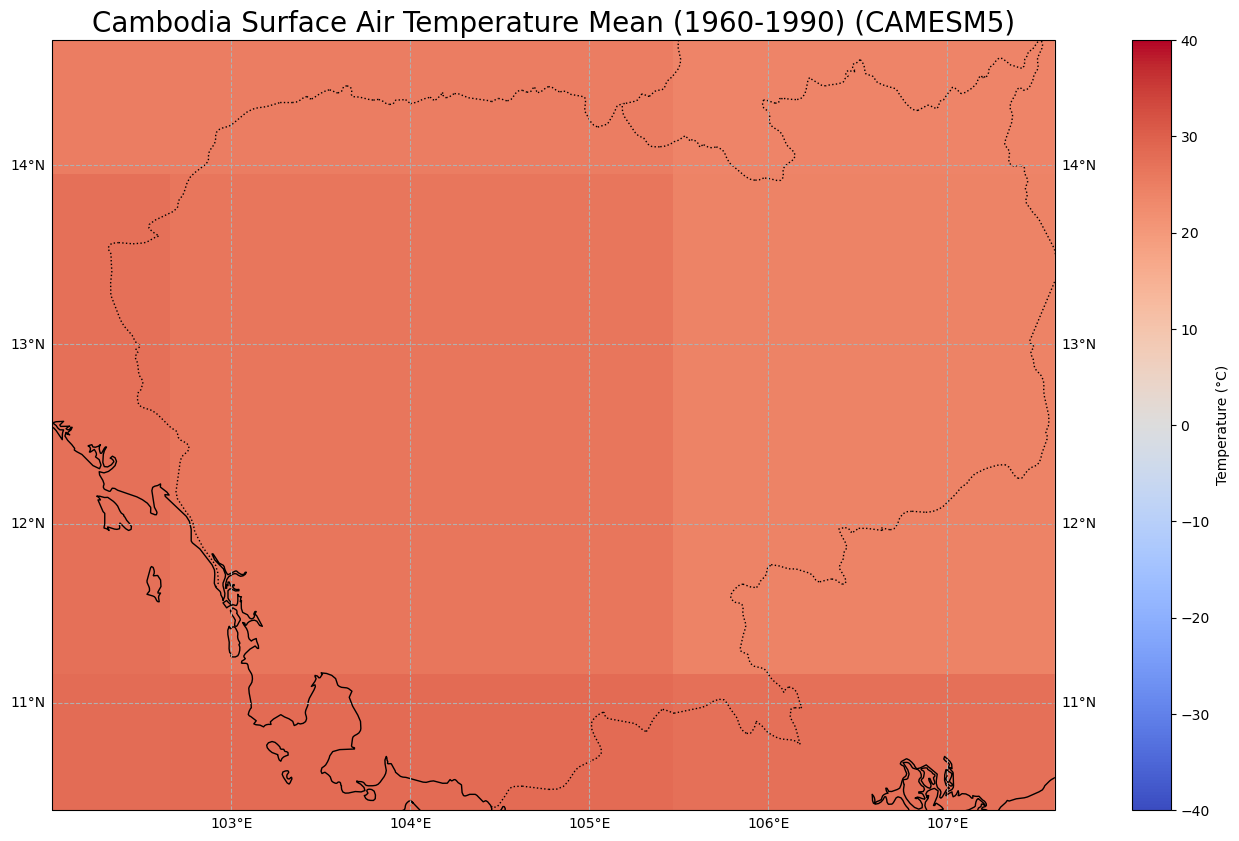

In [12]:
# CANESM5 1960-1990

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(can_hist_avg.lon, 
                     can_hist_avg.lat, 
                     can_hist_avg["tas"], 
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(cambodia, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Cambodia Surface Air Temperature Mean (1960-1990) (CAMESM5)", fontsize= 20)
plt.show()

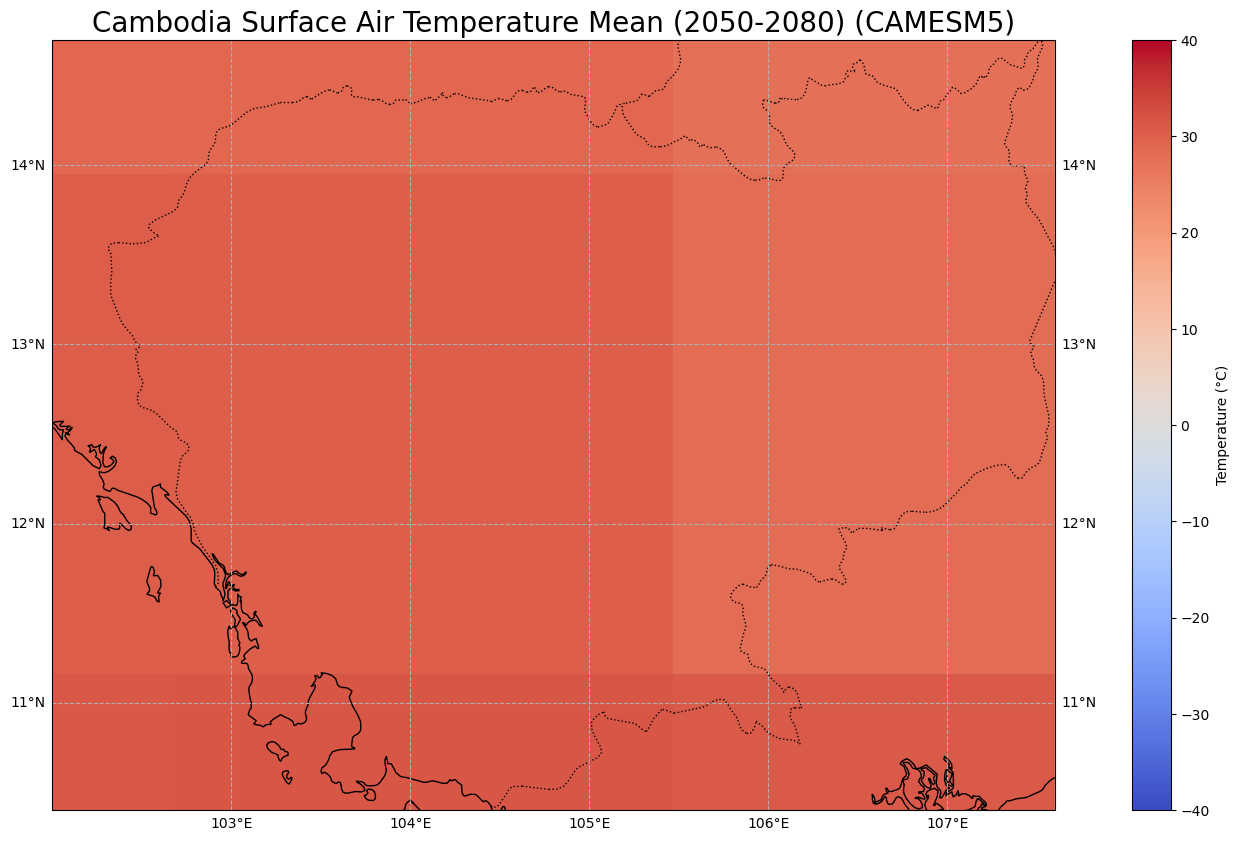

In [13]:
# CANESM5 2050-2080

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(can_fut_avg.lon, 
                     can_fut_avg.lat, 
                     can_fut_avg["tas"], 
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(cambodia, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Cambodia Surface Air Temperature Mean (2050-2080) (CAMESM5)", fontsize= 20)
plt.show()

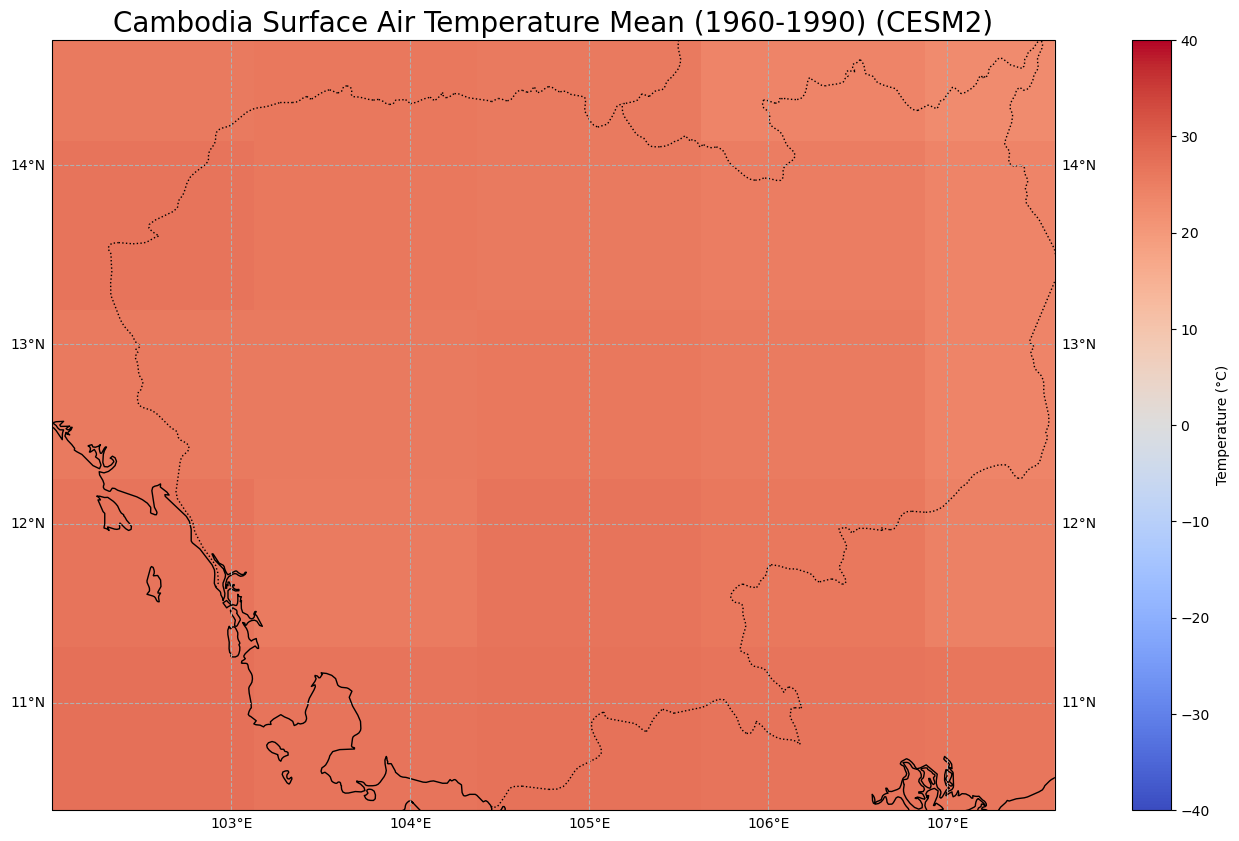

In [14]:
# CESM2 1960-1990

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(ces_hist_avg.lon, 
                     ces_hist_avg.lat, 
                     ces_hist_avg["tas"], 
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(cambodia, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Cambodia Surface Air Temperature Mean (1960-1990) (CESM2)", fontsize= 20)
plt.show()

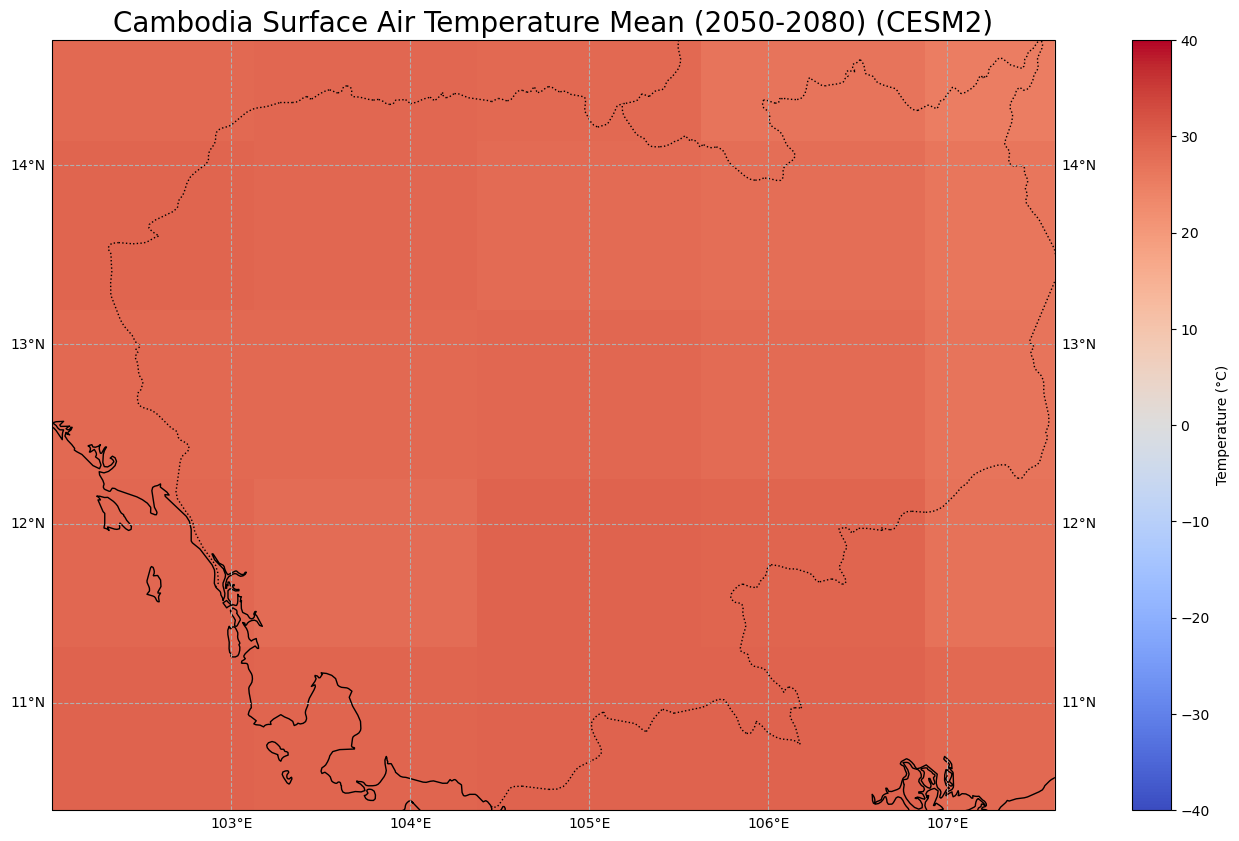

In [15]:
# CESM2 2050-2080

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(ces_fut_avg.lon, 
                     ces_fut_avg.lat, 
                     ces_fut_avg["tas"], 
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(cambodia, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Cambodia Surface Air Temperature Mean (2050-2080) (CESM2)", fontsize= 20)
plt.show()

## Map the difference in the averages between the two time periods 

We will look at [2050-2080] - [1960-1990] for the difference, starting with CanESM5

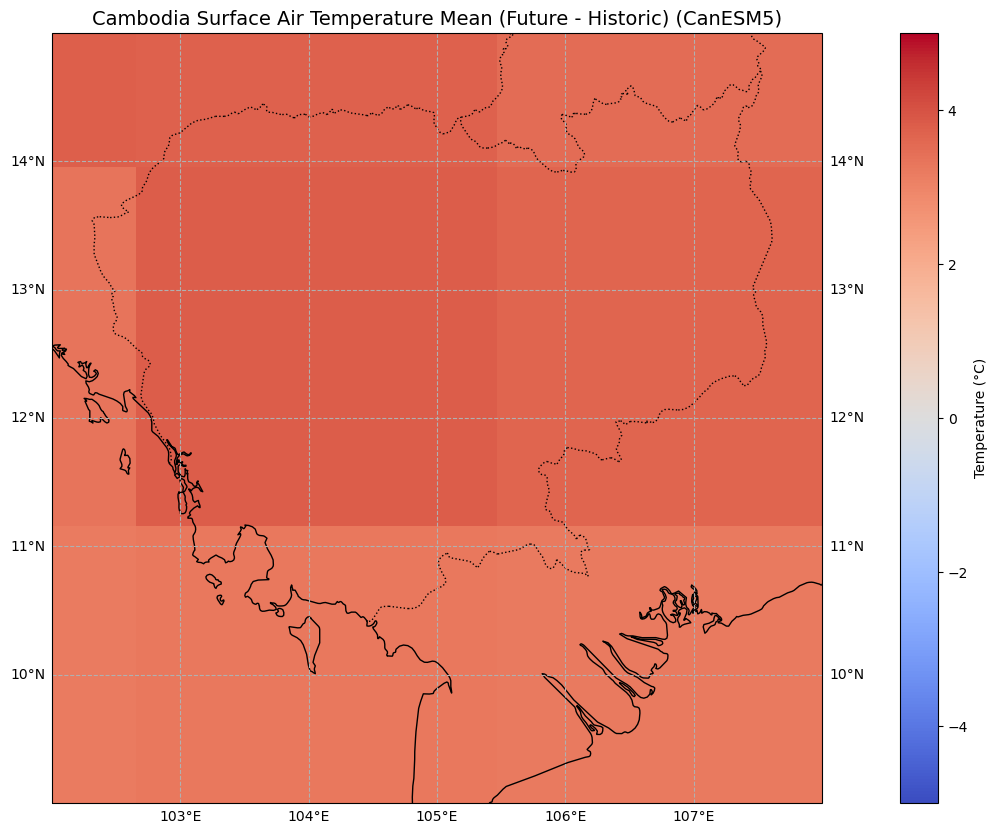

In [21]:
# CANESM5

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(can_fut_avg.lon, can_fut_avg.lat, can_fut_avg.tas.values - can_hist_avg.tas.values, 
                     transform=map, cmap="coolwarm", vmin=-5, vmax=5)

# Set spatial extent of plot
ax.set_extent(cambodia, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Cambodia Surface Air Temperature Mean (Future - Historic) (CanESM5)", fontsize= 14)
plt.show()

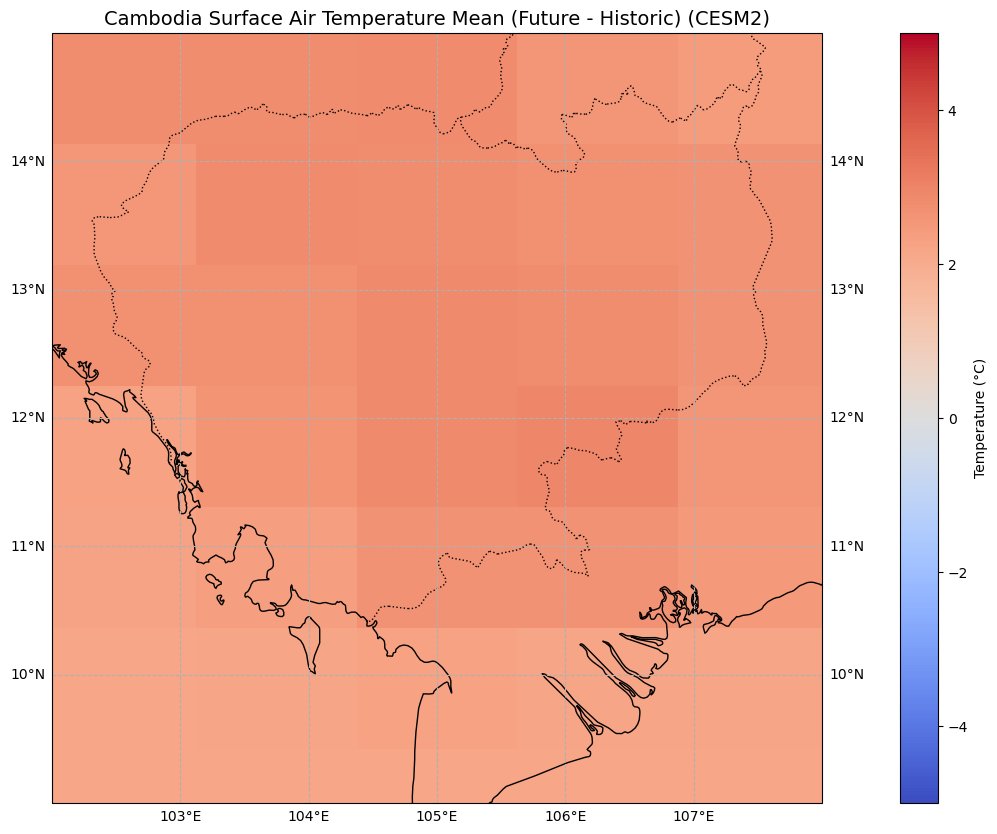

In [19]:
# CESM2

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(ces_fut_avg.lon, ces_fut_avg.lat, ces_fut_avg.tas.values - ces_hist_avg.tas.values, 
                     transform=map, cmap="coolwarm", vmin=-5, vmax=5)

# Set spatial extent of plot
ax.set_extent(cambodia, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Cambodia Surface Air Temperature Mean (Future - Historic) (CESM2)", fontsize= 14)
plt.show()

## Results

![image of cambodia](https://cdn.britannica.com/39/4039-050-FA851D93/Cambodia-map-boundaries-cities-locator.jpg)

I included an image of Cambodia to provide context for the regions affected.

Between the two models used here (CANESM5 and CESM2), they predict different areas to have the most change in air temperature. CanESM5 predicts for the Western half of Cambodia, including major cities of Phnom Penh, Siem Riep, Battambang and all areas around Tonle Sap lake. These are all main agricultural areas, particularly for rice. As said before, increased temperatures can lead to changes in rainfall patterns and stress on the crops, impacting commerce and even health. 

CanESM5 also shows a greater overall temperature compared to the CESM2 model. Only the southern region of Cambodia in this model shows a relatively smaller temperature change, and this area includes the coastal city of Kampom Saom (Preah Sihanouk) and the bamboo islands. However, this area does still face at least a 2 degree increase in temperature, which can contribute to sea level rise and warming of water temperatures. This can be especially harmful considering the reliance of fishing and tourism for these coastal areas and islands.

The CESM2 model instead shows the greatest difference in the South West corner of Cambodia, including the city of Kampong Cham and others on the border of Vietnam, and to a slightly lesser extent, Kampong. These are also main agricultural areas, with Kampong cham known for growing rice, cassava, fruits, and especially ruber for its proximity to the Mekong river. Kampot is known for rice, cassava, and the prized Kampot pepper. Changes in the environment can cause the pepper plants to fail to thrive, which is a major part of exports and tourism.

These models show a looming increase in temperatures, with the severity depending on the region in tyhis already hot and humid area. Each region offers its own benefits in agriculture, tourism and commerce, and those can be directly affected by global warming. Beyond human impacts, the ecosystems of these areas can be negatively affected has organisms can find themselves unable to adapt to the rapid temperature increase4 and subsequent habitat changes.

## References 
Swart, Neil C., et al. "The Canadian Earth System Model version 5 (CanESM5.0.3)." Geoscientific Model Development, vol. 12, no. 11, 2019, pp. 4823–4873. https://doi.org/10.5194/gmd-12-4823-2019.

Danabasoglu, G., Lamarque, J.-F., Bacmeister, J., et al. (2020). The Community Earth System Model Version 2 (CESM2). Journal of Advances in Modeling Earth Systems, 12(2), e2019MS001916. https://doi.org/10.1029/2019MS001916

Cambodia. Encyclopaedia Britannica, Encyclopaedia Britannica, Inc., 12 Apr. 2025, www.britannica.com/place/Cambodia.